In [2]:
from tqdm.notebook import tqdm
import pandas as pd
import time
import FinanceDataReader as fdr 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
import ta


# 데이터 불러오기 및 함수 설정

In [3]:
data = fdr.DataReader('005930', '2020','2022')

def plt_plot(x, name):
    plt.figure(figsize = (10, 5))
    plt.plot(x,label = 'vwap',lw=.8)
    plt.title('{}'.format(name))
    plt.ylabel('{} values'.format(name))
    _=plt.show


# Volume 지표

## MFI 
14일동안 평균가격을 거래량과 곱하여 현재 가격과 전일 가격을 비교하여 Positive, Negative의 money flow를 계산하고 구함 매수시점과 매도시점을 판단하는 지표

https://superhky.tistory.com/166

In [4]:
# 식은 대충 이렇다

typical_price = (data['Close'] + data ['High']+data ['Low'])
money_flow = typical_price * data['Volume']

positive_flow=[] 
negative_flow=[]

for i in range(1, len(typical_price)): # 현재 평균가격과 전일 평균가격을 비교하여 각 조건에 해당하는 데이터를 저장한다
    if typical_price[i] > typical_price[i-1]:
        positive_flow.append(money_flow[i-1])
        negative_flow.append(0)
    elif typical_price[i] < typical_price[i-1]:
        negative_flow.append(money_flow[i-1])
        positive_flow.append(0)
    else:
        positive_flow.append(0)
        negative_flow.append(0)
        
positive_mf = []
negative_mf = []
period=14
for i in range(period-1, len(positive_flow)):
    positive_mf.append(sum(positive_flow[i+1-period : i+1]))
for i in range(period-1, len(positive_flow)):
    negative_mf.append(sum(negative_flow[i+1-period : i+1]))
    
mfi = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))



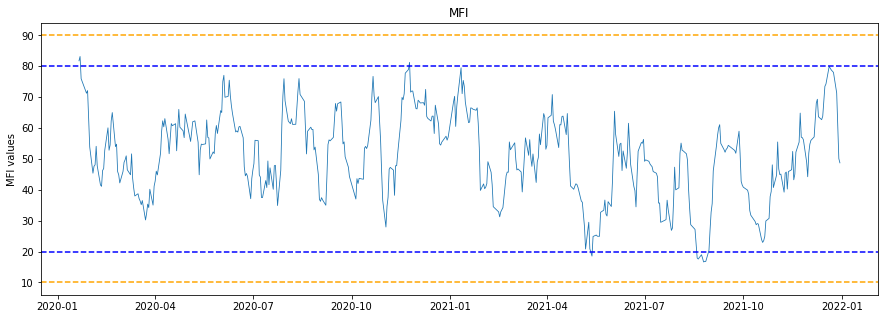

In [5]:
MFI = ta.volume.money_flow_index(data ['High'],data ['Low'],data['Close'],data['Volume'])
plt.figure(figsize = (15, 5))
plt.plot(MFI,label = 'mfi',lw=.8)
plt.axhline(10, linestyle= '--', color = 'orange')
plt.axhline(20, linestyle= '--', color = 'blue')
plt.axhline(80, linestyle= '--', color = 'blue')
plt.axhline(90, linestyle= '--', color = 'orange')
plt.title('MFI')
plt.ylabel('MFI values')
_=plt.show

 결론 : 80%를 넘으면 과잉  매수, 20% 밑으로 내려가면 과잉 매도

##  ADI
(매집/분산지표) A/D 는 가격과 거래량의 변화를 포함한 지표(. 거래량이 어느정도 상승하는 경우에 매입을 하여야 하며, 어느정도 하락한 경우에 매도해야 하는지에 대해 가늠해 볼 수 있다.)

adi= ((data['Close'] - data['Low']) - (data['High'] - data['Close']) / (data['High'] - data['Low'])) *d ata['Volume']

https://blog.naver.com/breezehome50/222306774614



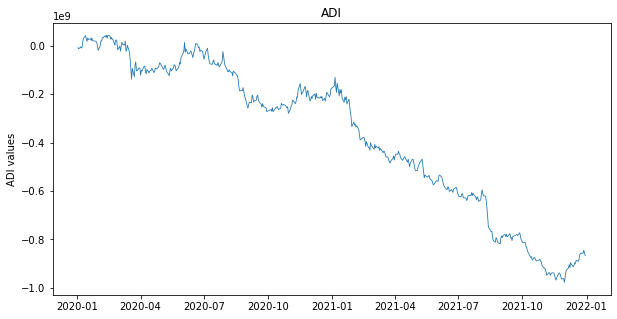

In [6]:
ADI = ta.volume.acc_dist_index(data['High'],data['Low'],data['Close'], data['Volume'])

plt_plot(ADI,'ADI')

결론 : 가격과 거래량을 이용하여 현재 추세의 강도를 측정하는데 목적이 있음. 이를 이용하여 다른지표와의 거래량과의 관계를 구하는 방향으로 확장되기도 함.

## OBV 
대표적인 시장강도 및 거래량 지표. 시장의 강도를 측정하기 위해서 한발짝 뒤에 숨어있는 데이터가 거래량이라는 생각을 바탕으로 고안된 지표.
 주가가 상승할 경우 거래량을 더하고 주가가 하락한 날의 거래량은 차감하며 거래량의 변동을 누적적으러 표현한 지표
 
 즉 같은 수준의 주가가 상승하더라도 거래량이 수반되지 않은 상승은 매수강도가 약하고 대규모 거래량을 수반한 주가의 상승은 매수강도가 강하다는 생각을 수치화한 지표 
 
식:
OBV= []

OBV.append(0)

for i in range(1, len(data.Close)):

    if data.Close[i] > data.Close[i-1]:
    
        OBV.append(OBV[-1] + data.Volume[i])
        
    elif data.Close[i] < data.Close[i-1]:
    
        OBV.append(OBV[-1] - data.Volume[i])
        
    else:
    
        OBV.append(OBV[-1])
 
 
 
 
 https://skyeong.net/281

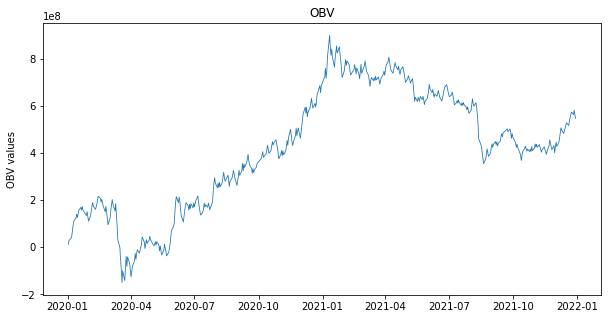

In [7]:

OBV= ta.volume.on_balance_volume(data['Close'], data['Volume'])
plt_plot(OBV,'OBV')

## CMF 
평균가격과 거래량을 모두 고려한 지표. 이걸 보고 매수/매도 하는 사람도 많음. 거래량에 대한 ma대비 AD에 대한 mae의 비율 중요한 지표임

Money Flow Multiplier = ((종가-저가)-(고가-종가))/(고가-저가)

Money Flow Volume = (Money Flow Multiplier) * 거래량

Chaikin Money Flow = sum(Money Flow Volume, period)/sum(V, period)



출처: https://mystorage1.tistory.com/571 [처음해보는 블로그]

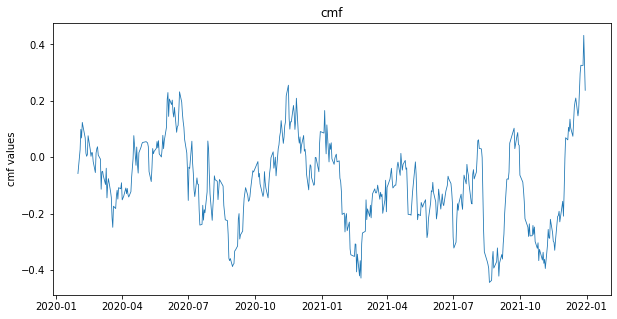

In [8]:
cmf=ta.volume.chaikin_money_flow(data['High'],data['Low'],data['Close'],data['Volume'])


plt_plot(cmf,'cmf')

## FI 
이도 역시 강도 지표 매수세력과 매도세력을 측정하여 나타내는 보조지표
금일 종가가 전일 종가보다 높으면 주가변동의 힘은 양의 값, 

반대로 낮으면 음의 값. 변동폭이 클수록 그리고 거래량이 많을 수록 주가변동의 힘은 더커짐



계산식은 ( 당일 종가- 전일종가) * 당일 거래량   당일 종가와 전일 종가의 차이에 거래량을 곱함.

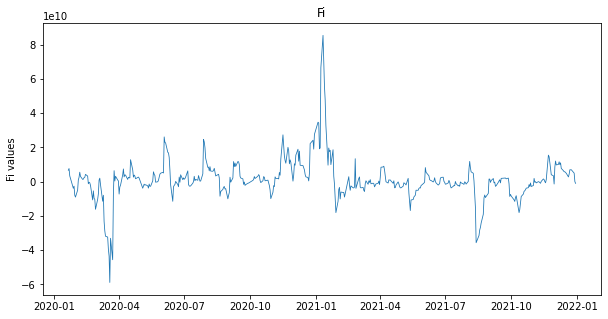

In [9]:
FI= ta.volume.force_index(data['Close'],data['Volume'])

plt_plot(FI,"Fi")

## Ease of Movement (EoM, EMV) 

- EOM은 거래량이 적은 상태에서 

주가가 상승 중일 때는 높은 수치를 나타내며 

거래량이 적은 상태에서 주가가 하락 중일 때는 낮은 수치를 나타납니다.

- 주가의 변동이 거의 없거나 변동은 있는데 거래량이 많은 경우 

EOM의 값은 거의 0에 가깝습니다.

- EOM이 0선을 상향 돌파하면 매수 신호, 

하향 돌파하면 매도 신호를 나타냅니다.
[출처] [EOM(Ease Of Movement) 모멘텀지표]수식관리자 기술적지표 키움증권 영웅문HTS 보조지표 조건검색식 지표조건설정 신호검색 강세약세|작성자 태권브이
ratio = 당일 거래량 / (당일 고가 -당일 저가)

movmid = Avg(당일 고가,당일 저가) - Avg(전날 고가,전날 저가)

EMV = movmid / ratio


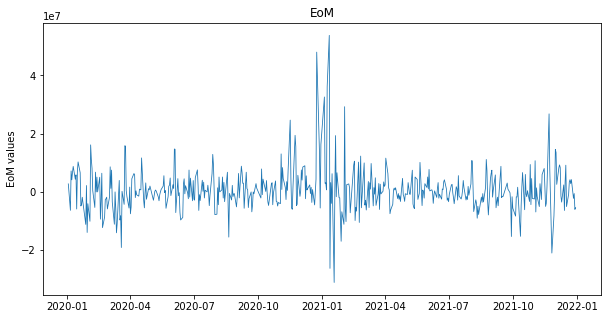

In [10]:
EoM= ta.volume.ease_of_movement(data['High'],data['Low'],data['Volume'])

plt_plot(EoM, 'EoM')

 ## VPT 
 obv를 수정한 거래량지표로써 obv가 n일간 상승일의 거래량을 누적합계와 하락일의 거래량 누적합계의 차를 나타내는데 비해 이건 전일 대비 당일의 가격상승율에 해당하는 거래량을 전일 vpt에 합하여 계산하는 지표
 
 vpt =[{(당일 종가 - 전일 종가) / 전일종가} * 당일 거래량] + 전일 vpt(첫날 vpt는 첫날 거래량으로 고정)

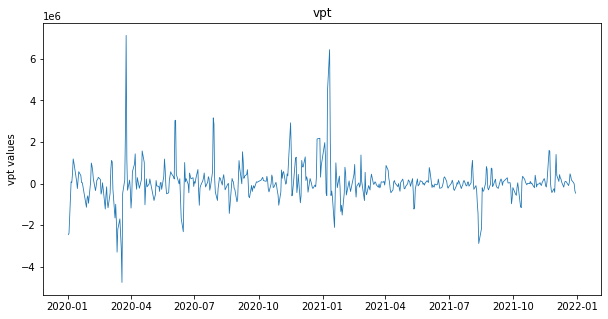

In [11]:
vpt = ta.volume.volume_price_trend(data['Close'],data['Volume'])

plt_plot(vpt,'vpt')

## NVI 
현명한 투자가는 거래량이 감소된 소강상태의 시장에서 매매를 행하는 반면에 일반 대중은 거래량이 충분히 증가된 상태에서 매매를 한다는 기본가정에서 출발한다. 따라서 이 지표는 전일에 비해서 거래량이 감소했을 경우에만 관심을 가진다 즉, 거래량을 전일과 비교했을 때 감소하는 날을 중심으로 만들어진 지표. 현재 주가가 활황장세인지 판단하는데 유용하게 사용. 반대 지표로는 pvi가 있음 이건 침체장을 판단하는데 사용

nvi = 전일 nvi + ((당일 종가 - 전일종가) / 전일종가) * 100    % 전일보다 높거나 같은 거래량의 nvi = 전일 nvi


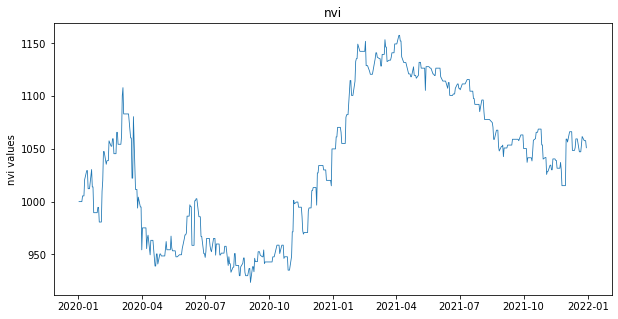

In [12]:
nvi =ta.volume.negative_volume_index (data['Close'],data['Volume'])

plt_plot(nvi,'nvi')

## vwap
하루 기준으로 현재 가격의 평균을 나타내주는 지표 (거래량 비중 평균가) 

누적(볼륨 x 일반 가격((H+L+C)/3))/누적(볼륨)

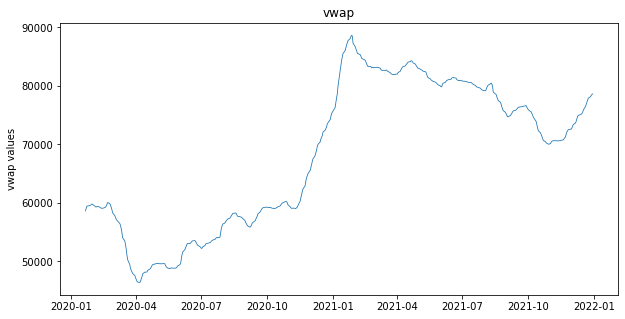

In [13]:
vwap = ta.volume.volume_weighted_average_price(data['High'],data['Low'],data['Close'],data['Volume'])

plt_plot(vwap,'vwap')

# Volatility 지표 

## Average True Range (ATR)
매수 매도를 판단하는 지표가 아닌 가격의 변동성을 체크하여 위험성을 관리하는 지표,

내가 투자할 주식이 지금 투자할 만한 구간인지 확인하기 위해,

이 3가지 경우에서 절대값이 가장 큰것이 TR이 됨  ATR은 이것을 평균화 한것

(1) 당일 고가 - 당일 저가

(2) 당일 고가 - 전일 종가

(3) 당일 저가 - 전일 종가


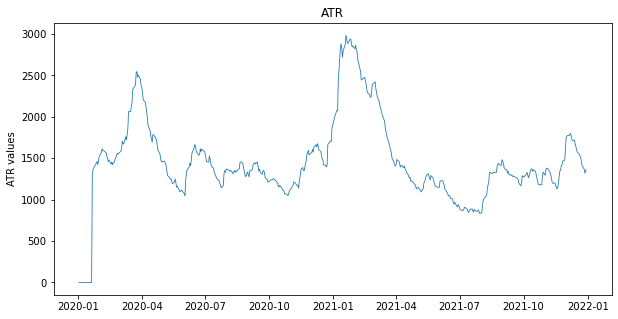

In [14]:
ATR=ta.volatility.average_true_range(data['High'],data['Low'],data['Close'])
plt_plot(ATR,'ATR')

## Bollinger Bands (BB)
N기간 동안의 이동평균(MA)

이동평균 위의 K배 표준편차 상위 밴드

이동평균 아래의 K배 표준편차 하위 밴드

일반적으로 N과 K의 값은 20과 2이다. 
평균값의 기본 선택의 단순 이동 평균이지만, 필요에 따라 다른 종류의 평균값을 쓸 수 있다. 지수 이동 평균(Exponential moving averages)은 일반적인 대안이다. 대개 중간 밴드와 표준 편차의 계산을 위해 같은 기간을 사용한다.

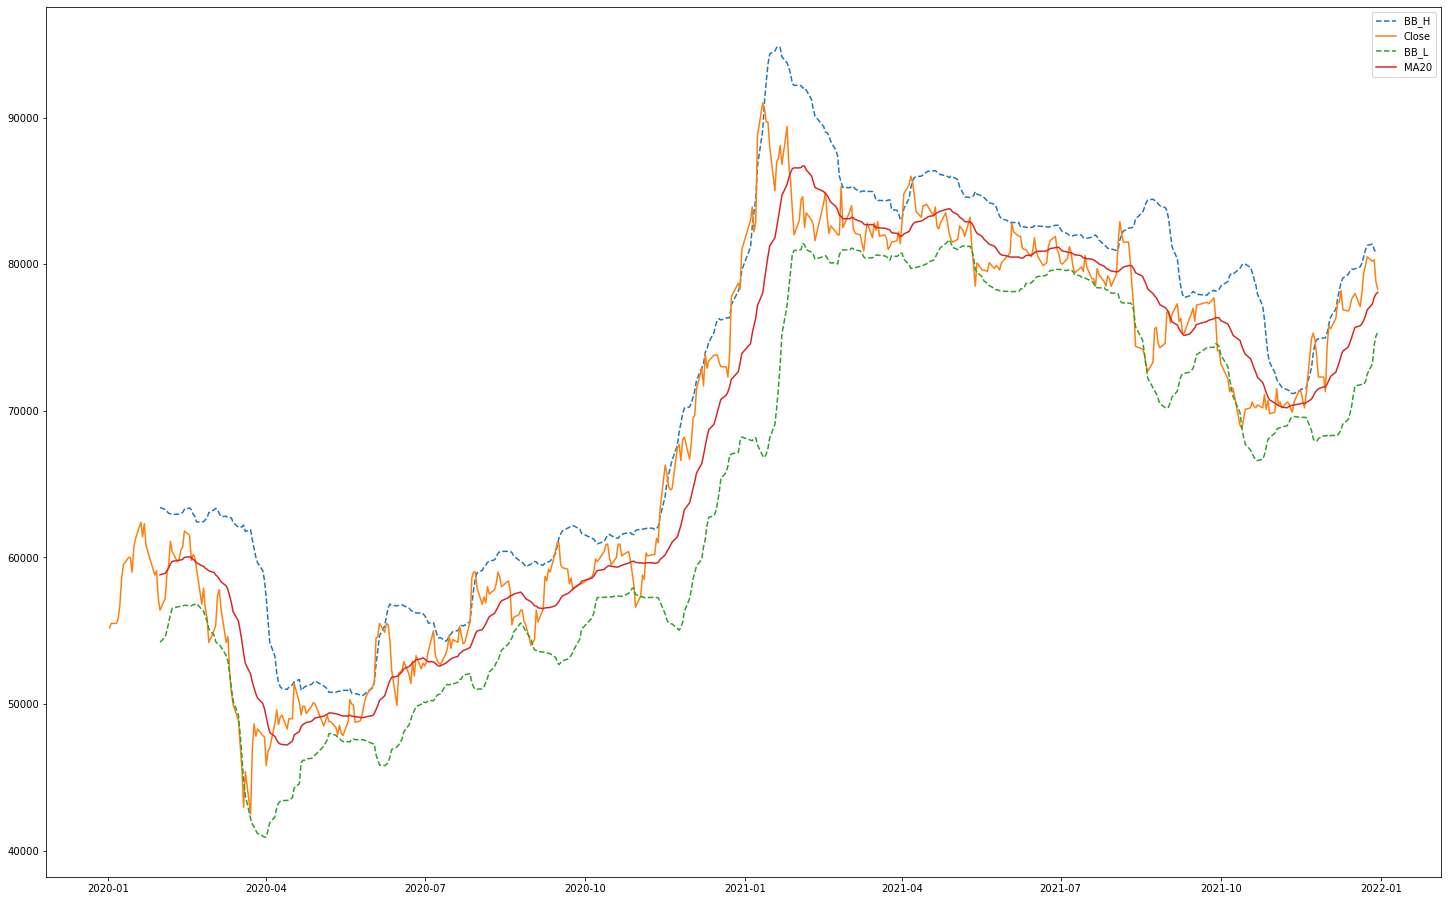

In [48]:
BB_H = ta.volatility.bollinger_hband(data['Close'], window_dev = 2)
BB_L = ta.volatility.bollinger_lband(data['Close'], window_dev=2)
SMA = ta.trend.sma_indicator(data['Close'],20)


plt.figure(figsize=(25, 16))
plt.plot(BB_H,linestyle='dashed', label='BB_H')
plt.plot(data['Close'],label='Close')
plt.plot(BB_L,linestyle='dashed', label='BB_L')
plt.plot(SMA,linestyle = '-', label = 'MA20')

plt.legend(loc='best')


# plt.plot(psar_up, label = "buy")
# plt.plot(psar_down,label = 'sell')
# KC_H = ta.volatility.keltner_channel_hband(data['High'],data['Low'],data['Close'])
# KC_L = ta.volatility.keltner_channel_lband(data['High'],data['Low'],data['Close'])
# KC_M = ta.volatility.keltner_channel_mband(data['High'],data['Low'],data['Close'])


# # plt.figure(figsize=(9, 5))
# plt.plot(KC_H,linestyle='dashed', label='KC_H')
# plt.plot(KC_M,linestyle='dashed', label = "KC_M")
# plt.plot(KC_L,linestyle='dashed', label='KC_L')
# plt.legend(loc='best')

## Keltner Channel (KC)
중간 선 : 20 일 지수 이동 평균 (EMA)

상단 채널 라인 : 20 일 EMA + (10 일 ATR x2)

낮은 밴드 : 20 일 EMA - (10 일 ATR x2)

일반적으로 Keltner Channel 지표는 BB보다 좁은 경향이 있습니다. 따라서, BB보다 트렌드 반전 및 과매 수 / 과매도 시장 상황을보다 명확하고 분명하게 파악하는 데 더 적합 할 수 있습니다. 또한 KC 지표는 일반적으로 BB보다 먼저 과매수 / 과매도 신호를 제공합니다. 


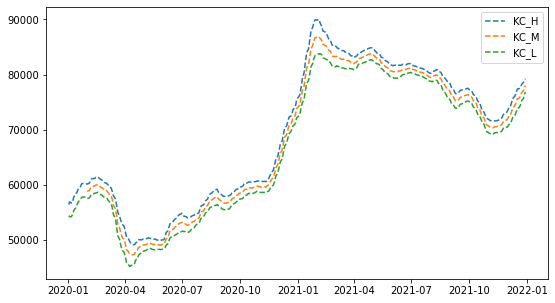

In [16]:
KC_H = ta.volatility.keltner_channel_hband(data['High'],data['Low'],data['Close'])
KC_L = ta.volatility.keltner_channel_lband(data['High'],data['Low'],data['Close'])
KC_M = ta.volatility.keltner_channel_mband(data['High'],data['Low'],data['Close'])


plt.figure(figsize=(9, 5))
plt.plot(KC_H,linestyle='dashed', label='KC_H')
plt.plot(KC_M,linestyle='dashed', label = "KC_M")
plt.plot(KC_L,linestyle='dashed', label='KC_L')
plt.legend(loc='best')

## Donchian Channel (DC)

특정 기간동안의 저가와 고가로 구성된 체널,

보통 20일을 기준으로 20일 최고치를 찍으면 매수, 최저치는 매도

periods를 기준으로 최대값과 최소값 설정

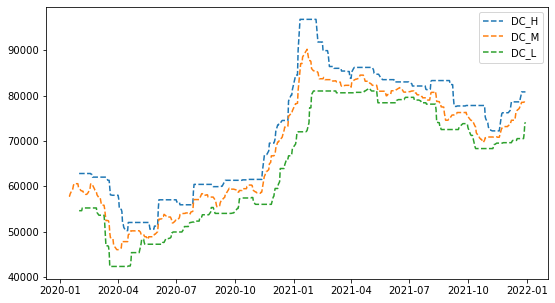

In [17]:
DC_H = ta.volatility.donchian_channel_hband(data['High'],data['Low'],data['Close'])
DC_L = ta.volatility.donchian_channel_lband(data['High'],data['Low'],data['Close'])
DC_M = ta.volatility.donchian_channel_mband(data['High'],data['Low'],data['Close'])

plt.figure(figsize=(9, 5))
plt.plot(DC_H,linestyle='dashed', label='DC_H')
plt.plot(DC_M,linestyle='dashed', label ="DC_M")
plt.plot(DC_L,linestyle='dashed', label='DC_L')
plt.legend(loc='best')

## Ulcer Index (UI)
UI는 가격의 하락의 넓이와 깊이의 관점에서 리스크를 판단하는 지수임 상승하는 것은 최근 고점에서 가격이 멀어진다는 것을 의미, 

보통 14일 기준 계산, UI 낙폭 비율로 표현이 되면서 거래자가 그 기간동안 겪을 만한 낙폭을 예측할 수 있다.


UI값이 클 수록, 주식이 이전 고점을 달성하는데 오래 걸린다는 것이다. 간단히 말해서, 저점에서의 변동성을 측정하기 위해 만들어 졌다.
계산은 세 가지 단계로 진행된다.

1. 낙폭 비율 = (종가 - 14일 간 최고 종가)/(14일 간 최고 종가) * 100

2. 제곱근의 평균 = (14일간 낙폭 비율 합산의 제곱근)/14

3. UI = 제곱근의 평균의 제곱근

[출처] Ulcer Index란 무엇인가?|작성자 FREESNR

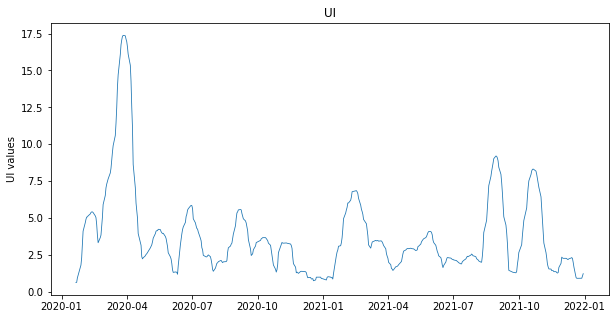

In [18]:
UI = ta.volatility.ulcer_index(data['Close'])
plt_plot(UI,'UI')

# Trend 지표

## Simple Moving Average (SMA)

기준일의 종가의 평균

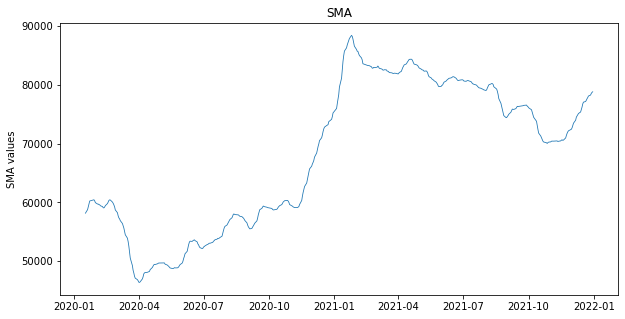

In [19]:
SMA = ta.trend.sma_indicator(data['Close'])

plt_plot(SMA,'SMA')

## Exponential Moving Average (EMA)
이동평균선과 동일하나 최근에 마감된 종가의 가중치를 부여  

둘다 추세확인을 하기 위한 지표

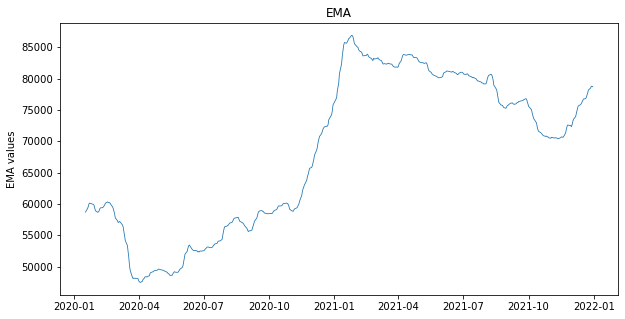

In [20]:
EMA = ta.trend.ema_indicator(data['Close'])

plt_plot(EMA,'EMA')

## Weighted Moving Average (WMA)

현재에 더 많은 가중치를 두고 과거의 값에는 더 적은 가중치를 두어, 현제의 추세를 잘 반영하기 위한 지표

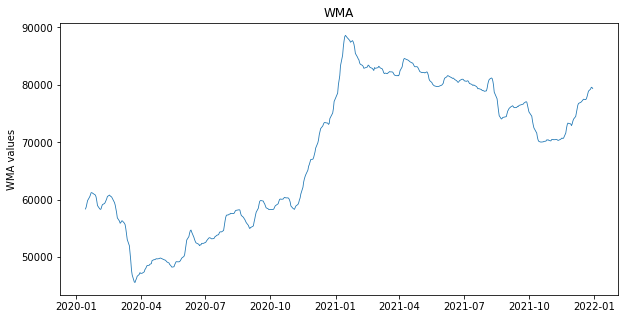

In [21]:
WMA = ta.trend.wma_indicator(data['Close'])

plt_plot(WMA, 'WMA')

## Moving Average Convergence Divergence (MACD)

MACD는 단기지수이동평균값과 장기지수이동평균값의 차이를 이용한 지표입니다.

이 지표는 두 이동평균선이 멀어지게 되면 다시 가까워지려고 하는 속성을 이용합니다. 두개의 이동평균선의 차이가 제일 큰 시점을 찾아내는데 주력하는 기법

12일,26일을 기준으로 한 지수이동평균선의 차이
최근 12일간 평균주가가 26일간의 평균주가를 상승돌파 하면 최근 흐름을 상승이라고 판단 가능



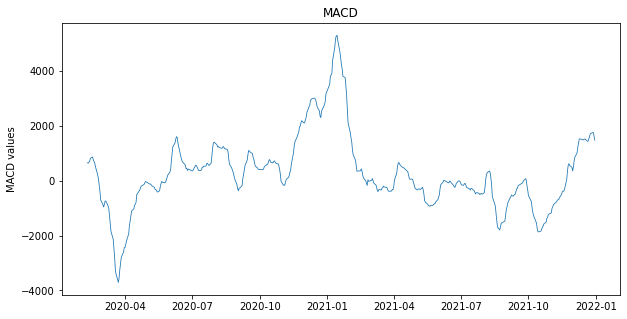

In [22]:
MACD = ta.trend.macd(data['Close'])

plt_plot(MACD, 'MACD')

## Average Directional Movement Index (ADX)
ADX는 현제 추세의 강한 정도를 나타냄. 다른 지표랑 사용해야함. DMI, ADX조합으로 사용을 많이함
DMI 지수에서 확인할 부분은 위에 표현된 DI Plus, DI Minus 입니다. ADX는 DMI를 확인할 때 보통 같이 확인하는 지표인데 뒤에서 설명 드리겠습니다. DI 두개를 구하기 위해서는 DM, TR 이라는 것을 계산해야 합니다.

DM (Directional Movement)

 상승 추세 일때는 금일의 고가가 반드시 전일의 고가 보다 높아야 하고, 하락 추세 일때는 금일의 저가가 반드시 전일의 저가 보다 낮아야 한다고 가정하고 계산합니다

 - 전일의 고가 보다 금일의 고가가 높을시 : +DM

 - 전일의 저가 보다 금일의 저가가 낮을시 : -DM

 - 위 상황이 둘다 발생했을 때,

   - 고가 상승 범위가 더 크다면 : +DM

   - 저가 하락 범위가 더 크다면 : -DM

 - 변동 자체가 전날의 변동보다 작다면 : DM = 0

 

- TR (True Range)

 아래의 세가지 경우 중 절대값이 가장 큰 값을 TR로 지정합니다.

  1. 금일의 고가 - 금일의 저가

  2. 금일의 고가 - 전일의 종가

  3. 금일의 저가 - 전일의 종가

 

위의 두가지를 각각 계산한 뒤에 DI를 계산합니다.

 

- DI(Directional Indicator)

   - DI = DM / TR

   - DI는 DM의 값에 따라 부호가 바뀌게 됩니다.

   - DM과 TR 하루치를 통해 DI를 계산하는게 아니라, 보통 M일 동안의 이동평균으로 계산합니다.

   - +DI = +DM의 M일 이동평균 / TR의 M일 이동평균

           = DI Plus

           = PDI

   - -DI = -DM의 M일 이동평균 / TR의 M일 이동평균

           = DI Minus

           = MDI

   - 이렇게 계산된 DI는 M일 동안 상승 추세, 또는 하락 추세에서 금일 주가의 비율 이라고 볼 수 있습니다.

 즉 DI Plus가 위에 있다면 상승 추세에 있다고 볼 수 있고, DI Minus가 더 위에 있다면 하락 추세에 있다고 볼 수 있죠. 그래서 DMI 지수를 이용한 매매 기법은 간단합니다.
https://dataplay.tistory.com/15


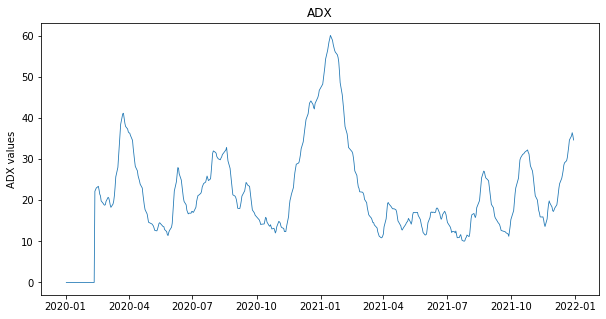

In [23]:
ADX=ta.trend.adx(data['High'],data['Low'],data['Close'])

plt_plot(ADX, 'ADX')

## Vortex Indicator (VI)
캔들의 최저점을 다음 캔들의 최고점과 연결하는 것을 반복한다

최저점과 최고점 사이의 거리가 클수록 vi + 값은 커짐.

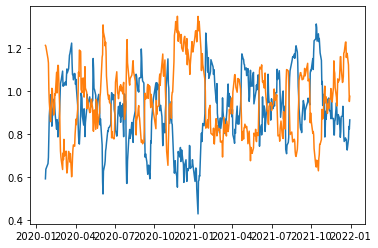

In [24]:
VI_N = ta.trend.vortex_indicator_neg(data['High'],data['Low'],data['Close'])
VI_P = ta.trend.vortex_indicator_pos(data['High'],data['Low'],data['Close'])

plt.plot(VI_N)
plt.plot(VI_P)

## Trix (TRIX)
이동평균선의 불필요한 데이터 값을 제거해주어 보다 명확하게 추세를 파악할 수 있고, 매매시점을 포착해낼 수 있는 장점이 있다. 

이동평균선을 3번 거쳐 완만하게 표현시켜줌
 
공식

EMA1 = 종가의 n일 지수 이동평균
EMA2 = EMA1의 n일 지수 이동평균
EMA3 = EMA2의 n일 지수 이동평균

TRIX = 100 * (금일의 EMA3 값 - 전일 EMA3 값 / 전일의 EMA3 값)

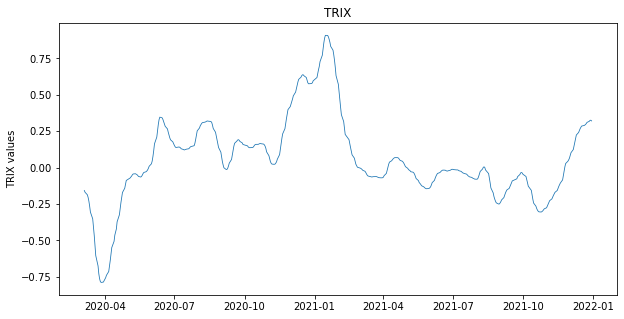

In [25]:
TRIX = ta.trend.trix(data['Close'])

plt_plot(TRIX,"TRIX")

## Mass Index (MI)
고가와 저가 사이의 변동폭을 계산해 추세의 전환점을 예측하는데 유용한 지표.
변동폭이 크면 MI는 증가하고 반대면 감소함
큰 인기가 없는 지표

공식

sum(eavg(H-L,9)/eavg(eavg(H-L,9),9),Period) (period = 25, 9) 

출처: https://mystorage1.tistory.com/552 [처음해보는 블로그]

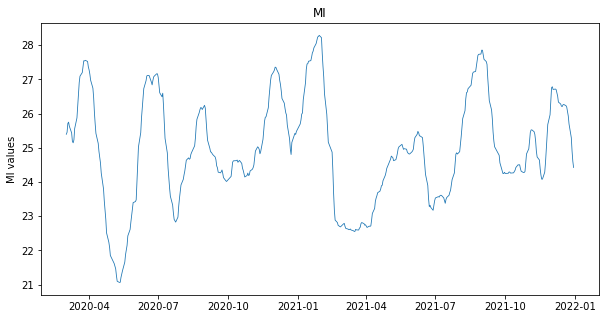

In [26]:
MI = ta.trend.mass_index(data['High'],data['Low'])
plt_plot(MI,"MI")

## Commodity Channel Index (CCI) 
현재 가격과 이동 평균값과 차이를 이용하여 미래의 방향성과 탄력성을 측정하는 보조지표

CCI = (TP - SMA) / (CV * MAD)
 

① TP : Typical Price (고가+저가+종가)/ 3

② SMA : Single Moving Average (TP의 n일동안 단순 이동평균)

③ MAD : Mean Absolute Deviation (TP-SMA)의 절대값의 이동평균 값 

④ CV : Constant Value (0.015 , CCI지표를 -100에서 100사이에 움직일 수 있도록 하는 상수 고정값임)


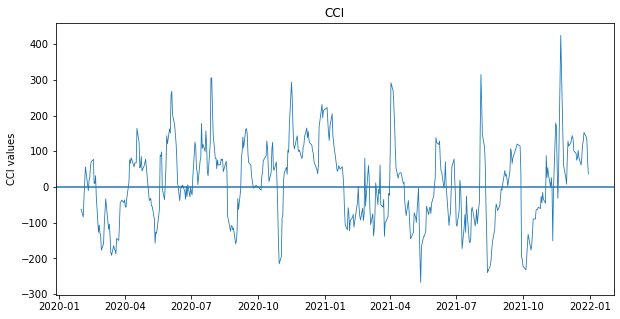

In [27]:
CCI = ta.trend.cci(data['High'],data['Low'],data['Close'])

plt_plot(CCI, 'CCI')
plt.axhline(0)

## Detrended Price Oscillator (DPO)
DPO는 가격에 이동평균을 이용하여 장기적인 가격 추세를 제거한 지표이다. 즉, 주된 기본 가격의 주기를 알기위해 작은 추세를 필터링한 것이다.

DPO가 0선을 상향돌파 -> 강세 (매수)

DPO가 0선을 하향돌파 -> 약세 (매도)

DPO = Close - avg(Close,n,((n/2)+1))

출처: https://mystorage1.tistory.com/548 [처음해보는 블로그]



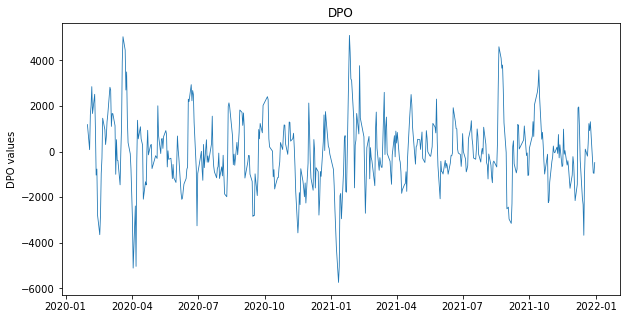

In [28]:
DPO = ta.trend.dpo(data['Close'])
plt_plot(DPO,"DPO")


## KST Oscillator (KST)
ROC1=(가격/가격(X1)-1)*100;}

ROC2=(가격/가격(X2)-1)*100;}

ROC3=(가격/가격(X3)-1)*100;}

ROC4=(가격/가격(X4)-1)*100;}


http://search.cpan.org/~kmx/Finance-TA-v0.4.1/TA.pod#TA_ROC_(Rate_of_change_:_((price/prevPrice)-1)*100)

가격은 현재 종가를 나타내고 가격(X1)은 X1 바 전 종가를 나타냅니다.

KST=MOV(ROC1,AVG1)*W1+MOV(ROC2,AVG2)*W2+MOV(ROC3,AVG3)*W3+MOV(ROC4,AVG4)*W4

여기서 MOV(ROC1,AVG1)는 ROC1의 AVG1 일 이동 평균을 나타냅니다.

단기 추세에 대해 Martin J Pring은 다음 매개변수를 제안합니다.

X1 = 10
X2 = 15
X3 = 20
X4 = 30
AVG1 = 10
AVG2 = 10
AVG3 = 10
AVG4 = 15
W1 = 1
W2 = 2
W3 = 3
W4 = 4

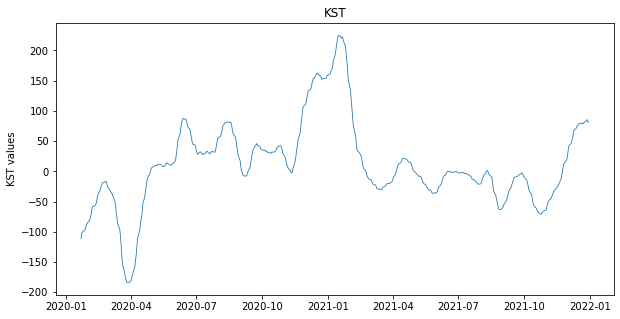

In [29]:
KST = ta.trend.kst(data['Close'])
plt_plot(KST,'KST')

## Ichimoku Kinkō Hyō (Ichimoku)

재물에 대한 지지 및 저항, 모멘텀 및 추세 방향을 보여주는 대중적이고 유연한 지표입니다. 이것은 한 눈에 가격 활동의 명확한 그림을 제공합니다. 

https://school.stockcharts.com/doku.php?id=technical_indicators:ichimoku_cloud

Ichimoku Cloud 내의 5개 플롯 중 4개는 주어진 기간 동안의 최고점과 최저점의 평균을 기반으로 합니다. 

예를 들어, 첫 번째 그림은 단순히 9일 고가와 9일 저가의 평균입니다. 
컴퓨터가 널리 보급되기 전에는 9일 이동 평균보다 이 고저 평균을 계산하는 것이 더 쉬웠을 것입니다. Ichimoku Cloud는 5개의 플롯으로 구성됩니다.

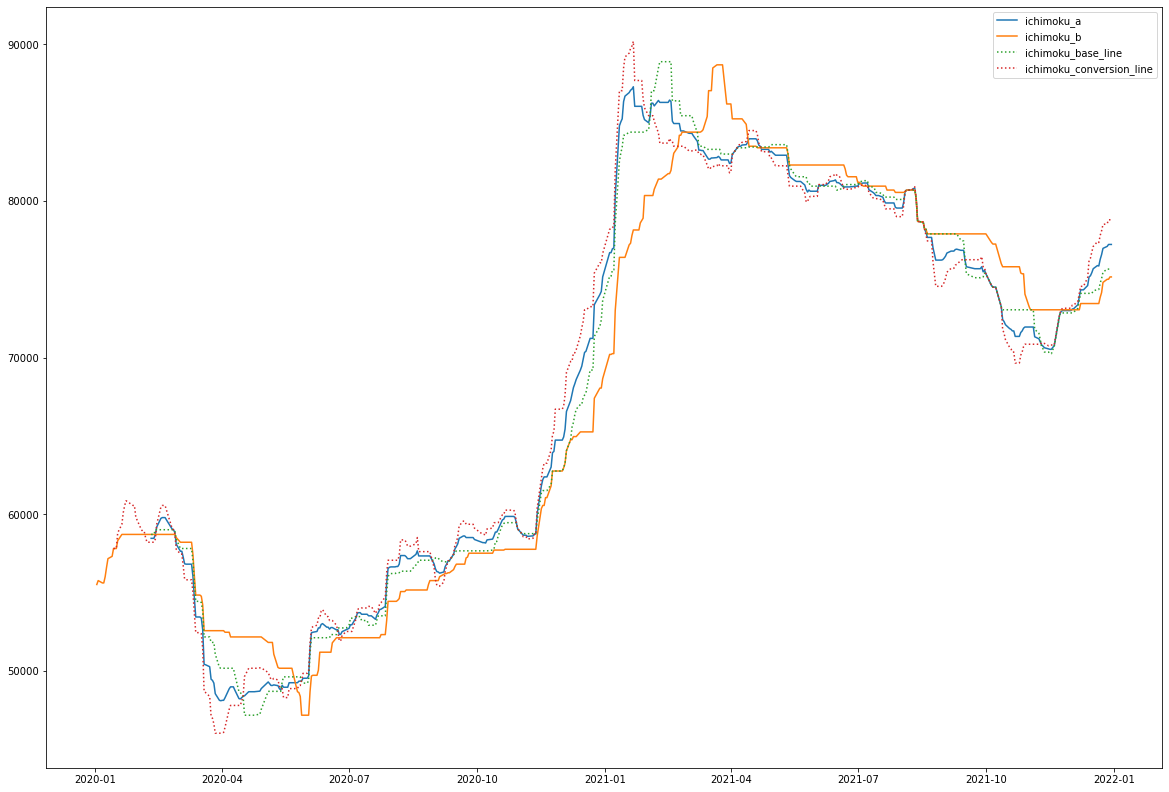

In [52]:
ichimoku_a =ta.trend.ichimoku_a(data['High'],data['Low'])
ichimoku_b = ta.trend.ichimoku_b(data['High'],data['Low'])
ichimoku_base_line= ta.trend.ichimoku_base_line(data['High'],data['Low'])
ichimoku_conversion_line = ta.trend.ichimoku_conversion_line(data['High'],data['Low'])

plt.figure(figsize=(20, 14))

plt.plot(ichimoku_a,label = "ichimoku_a",)
plt.plot(ichimoku_b, label = "ichimoku_b")
plt.plot(ichimoku_base_line, label = "ichimoku_base_line",linestyle='dotted' )
plt.plot(ichimoku_conversion_line, label= "ichimoku_conversion_line",linestyle='dotted' )
plt.legend(loc='best')

## Parabolic Stop And Reverse (Parabolic SAR)

추세 전환을 예고하는 지표로서 포물선(Parabola)와 SAR(정지 및 반전 Stop And Reverse)

의 합성어 입니다. 추세를 형성하고 있는 주가에서 가속력이 떨어지면 추세 전환의 신호가 된다는 이론

SAR = SAR(*) + [AF(EP-SAR(*)]


SAR(*) : 전일 SAR

AF (Acceleration Factor : 가속변수)

가중치로써 시간이 지나면서 값이 증가하면서 파라볼릭 값이 더 빠르게 변화합니다. 

보통 0.02~0.2까지 수치값을 사용합니다.


0.02부터 시작하여 최고가/신고가가 나오면 +0.02씩 증가

10번의 신고가/신저가를 갱신하면 최고 0.2까지 로 고정

AF의 값을 높게할수록 추세 변화에 민감해집니다.
[출처] Parabolic SAR 지표(파라볼릭 SAR) - 기술적 분석|작성자 별별


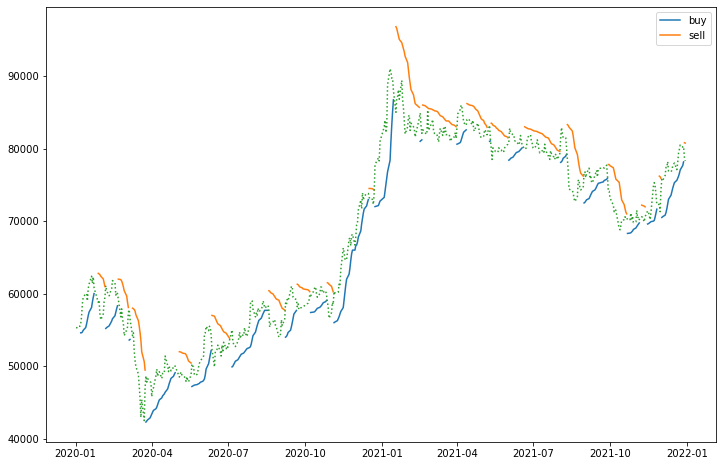

In [31]:
psar_down = ta.trend.psar_down(data['High'],data['Low'],data['Close'])
psar_up = ta.trend.psar_up(data['High'],data['Low'],data['Close'])

plt.figure(figsize=(12, 8))
plt.plot(psar_up, label = "buy")
plt.plot(psar_down,label = 'sell')
plt.plot(data["Close"],linestyle='dotted')
plt.legend(loc='best')

##  Schaff Trend Cycle (STC)
 시장 동향을 식별하고 거래자에게 매수 및 매도 신호를 제공하는 데 일반적으로 사용되는 차트 지표입니다.
 
 MACD와 동일한 지수 이동 평균 을 사용하여 계산되지만 정확도와 신뢰성을 향상시키기 위해 새로운 주기 구성 요소를 추가합니다. MACD는 단순히 일련의 이동 평균을 사용하여 계산되지만 STC의 주기 측면은 시간(예: 일 수)을 기반으로 합니다.

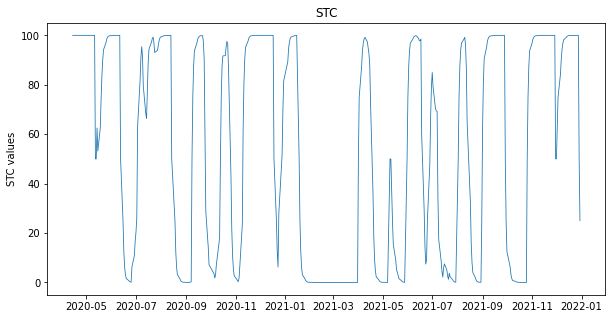

In [32]:
STC = ta.trend.stc(data['Close'])
plt_plot(STC, 'STC')

# Momentum 지표

## Relative Strength Index (RSI)
일정기간 동안 가격 상승폭과 하락폭 중 어느 쪽이 더 높냐를 나타내는 것으로 0에 가까우면 하락강도가 강하다는 뜻.

RSI = AU / (AU + AD) * 100

U = 전일 보다 상승한 날의 상승분

D = 전일 보다 하락한 날의 하락분

AU = 일정기간 U의 평균

AD = 일정기간 D의 평균

RS = AU / AD



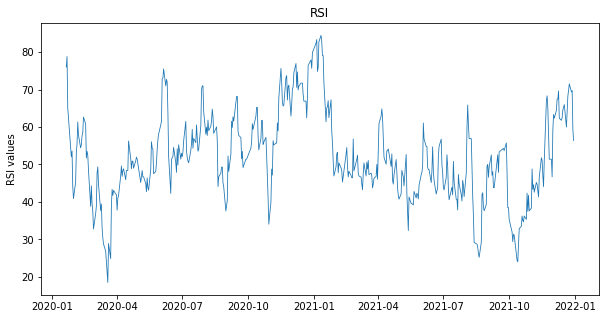

In [33]:
RSI = ta.momentum.rsi(data['Close'])

plt_plot(RSI,'RSI')

## Stochastic RSI (SRSI) 
과매수 혹은 과매도 되었는지를 판단하는 기술적 분석 지표

Stochastic RSI = (현 시점 RSI - 최저점 RSI) / (최고점 RSI - 최저점 RSI)

과매수 신호는 80% 이상이 해당, 과매도는 20% 이하


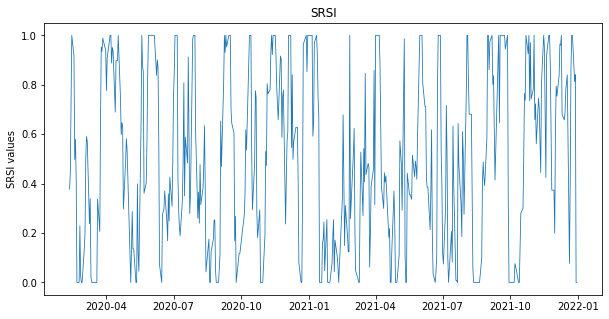

In [34]:
SRSI = ta.momentum.stochrsi(data['Close'])

plt_plot(SRSI,'SRSI')


## True strength index (TSI)
RSI와 유사하지만 상승과 하락강도를 한번에 적용함으로서 시장의 실질적인 변동폭을 알 수 있도록 고안된 지표

두번의 장단기 지수이동평균으로 SMOOTIHIN 시켜 왜곡된 주가 흐름을 방지하는데 효과적인 지표
-100 과 100 사이의 범위를 가짐. 

공식 = n일간의 지수이동평균 ( r일간의 전일종가- 금일종가 지수이동평균) / n일간의 지수이동평균(r일간의 전일종가 - 금일종가의 절대값 지수이동평균)  n= 26일 , s = 12일

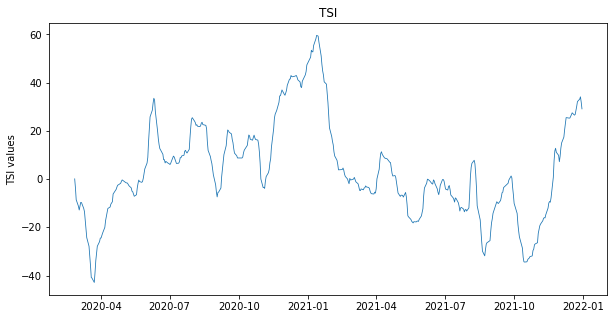

In [35]:
TSI = ta.momentum.tsi(data["Close"])
plt_plot(TSI,"TSI")

## Ultimate Oscillator (UO)
주가 움직임의 모멘텀을 측정하기 위해 쓰이는 모멘텀 지표입니다. 서로 다른 세 개의 기간대 동안의 주가 움직임을 하나의 오실레이터로 결합한 것으로, 시간의 길이에 관계없이 대부분의 oscillator 개념을 설명합니다.

미래의 움직임과 관련될 수 있는 정보들을 단 하나의 기간으로만 판단하는 ocillator들과 달리, Ultimate Oscillator는 정보의 범위를 넓혀서 주식 가격 모멘텀의 완전한 그림을 얻고 함정을 피하기 위해 이용합니다.

Ultimate oscillator의 방정식에 쓰이는 수식들은 아래와 같습니다.

true low = min(전날 종가, 당일 최저가)

true high = max(전날 종가, 당일 최고가)

true range(tr) = true high - true low

매수 압력(buying pressure,bp) = 종가 - min(전날 종가, 당일 최저가) = 종가- true low

매도 압력(selling pressure,sp) = 종가 - max(전날 종가, 당일 최고가) =종가 -true high

전날 종가와 당일 최저가의 가격이 같을 시, bp=0

전날 종가와 당일 최고가의 가격이 같을 시, sp=0
전날 종가가 10,000원이고 오늘 최저가가 12,000이면 매수 압력은 2,000원입니다.

전날 종가가 10,000원이고 오늘 최고가가 12,000이면 매도 압력은 -2,000원입니다

전날 종가가 10,000원이고 오늘 최저가가 9,000원/최고가가 12,000원이면

true range = true high - true low = 12,000 - 9,000 = 3,000

만약 period 7에서 bp1을 오늘, bp2을 어제, ... bp7을 일주일 전이라고 가정할 때, true range 범위내에서의 평균가격(avg)는

평균가격(avg7) = (bp1+bp2+...bp7)/(tr1+tr2+...tr7)

Ultimate oscillator(7,14,28) =(4*avg7+2avg14+avg28)/ (4+2+1)
(∵ 1/7 : 1/14 : 1/28 = 4:2:1)

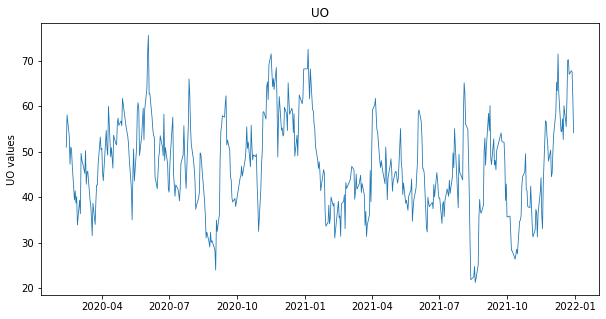

In [36]:
UO = ta.momentum.ultimate_oscillator(data['High'],data['Low'],data['Close'])

plt_plot(UO,"UO")

## Stochastic Oscillator (SR)
주로 차트의 추세를 파악하는데 사용합니다. 최근 N일간의 최고가와 최저가의 범위 내에서 현재 가격의 위치를 백분율로 표시한 지표입니다. 

 스토캐스틱 지표는 Fast와 Slow로 나뉘고, 각각의 %K, %D를 구합니다. Fast는 주가에 너무 민감하게 반응하기 때문에 스캘핑 등 아주 짧은 주기의 단타를 하시는 분들만 사용하고, 일반적으로 Slow를 매매에 활용하게 됩니다.



출처: https://dataplay.tistory.com/14 [데이터 놀이터]

## Williams %R (WR)
일정 기간 중 최고가와 최저가를 중심축으로 해서 현재가가 중심축의 어너 위치에 있는지를 %로 표시한 것으로 주가의 천장과 바닥을 판단하는데 유용한 튜자지표
과매수와 과매도 수준을 측정하는데 인기가 있음. 눈금은 0~100이며 0~-20은 과매수, 그리고 -80~-100은 과매도로 간주

공식 =[ (n기간의 최고가 - 종가)/(n기간의 최고가 - n기간의 최적)] * -100


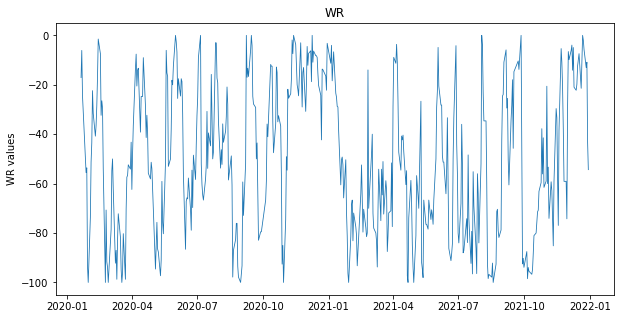

In [37]:
WR = ta.momentum.williams_r(data['High'],data['Low'],data['Close'])
plt_plot(WR,'WR')

## Awesome Oscillator (AO)
시장 추진력의 정확한 변화를 반영하는 모멘텀 지표로, 추세의 강점을 형성 및 반전 지점까지 식별할 수 있게 해줍니다.

중간가격 = (고+저)/2
AO = SMA(중간 가격(5일)) - SMA(중간가격 (34일))

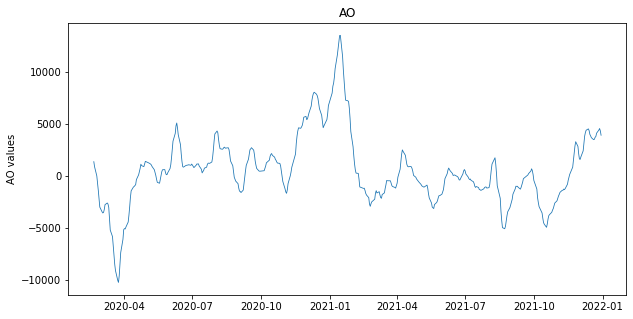

In [38]:
AO = ta.momentum.awesome_oscillator(data["High"], data['Low'])
plt_plot(AO,"AO")

##  Kaufman's Adaptive Moving Average (KAMA)
 시장 소음 또는 변동성을 설명하도록 설계된 이동 평균입니다. 
 
 KAMA는 가격 변동이 상대적으로 작고 소음이 낮을 때 가격을 면밀히 추적합니다. 
 
 KAMA는 가격 변동이 확대되면 조정하고 더 먼 거리에서 가격을 따릅니다. 
 
 이 추세 추종 지표는 전반적인 추세, 전환점을 식별하고 가격 움직임을 필터링하는 데 사용할 수 있습니다.
 
 ER = Change/Volatility

Change = ABS(Close - Close (10 periods ago))

Volatility = Sum10(ABS(Close - Prior Close)) (최근 10개 의 절대값의 합)

SC = [ER x (가장 빠른 SC - 가장 느린 SC) + 가장 느린 SC]2   평활상수

현재 KAMA = 이전 KAMA + SC x (가격 - 이전 KAMA) 첫번째 kama는 단순 이동 평균

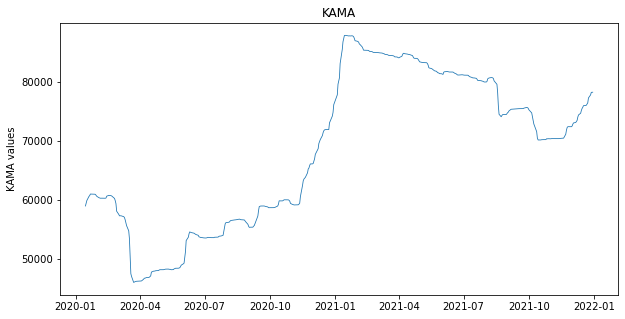

In [39]:
KAMA = ta.momentum.kama(data["Close"])
plt_plot(KAMA,"KAMA")

## Rate of Change (ROC)
과거 일정 시점의 가격과 현재의 가격을 비교함으로써 현재 가격의 상승추세에 있는지 하락 추세에 있는지 판단하는 지표

roc = 0 횡보

roc = + 상승추세, 현재 가격이 n일전보다 높음

roc = - 하락추세, 현재 가격이 n일전보다 낮음

ex) 12일 roc가 30: 현재의 주가가 과거 12일 전 주가보다 30% 상승

momentum = 당일 종가 /n일전 종가 * 100

roc = ((당일 종가 - n일전 종가) / n일전 종가) *100

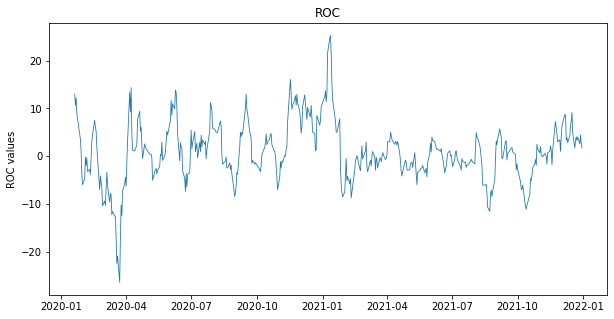

In [40]:
ROC = ta.momentum.roc(data["Close"])

plt_plot(ROC,"ROC")

## Percentage Price Oscillator (PPO)
가격과 지수이동평균(EMA)의 이격도를 측정하는 보조지표 

단기이동평균과 장기이동평균의 차이를 비교분석하여 %의 선을 보여주게 됨.

두선의 이격도 차이를 주식의 추세와, 매수매도시점을 분석하는데 사용

PPO = ((단기이동평균 - 장기이동평균) / 단기이동평균 ) * 100


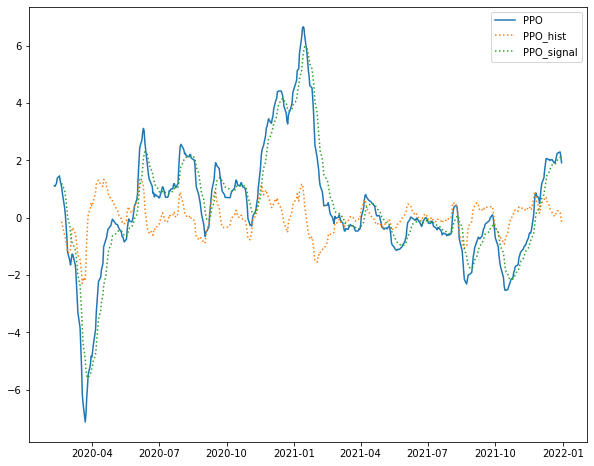

In [41]:
PPO = ta.momentum.ppo(data["Close"])
PPO_hist = ta.momentum.ppo_hist(data["Close"])
PPO_signal = ta.momentum.ppo_signal(data["Close"])

plt.figure(figsize=(10,8))
plt.plot(PPO, label = 'PPO', )
plt.plot(PPO_hist, label = 'PPO_hist',linestyle= "dotted")
plt.plot(PPO_signal, label = 'PPO_signal',linestyle= 'dotted')
plt.legend(loc='best')

## Percentage Volume Oscillator (PVO)

볼륨 이동평균선이라고 생각하면 좋다.
골드크로스, 데드크로스가 이평선보다 훨씬 선행. 하지만 민감하게 반응하기 때문에 이평선과 함께 보는 것이 좋다.



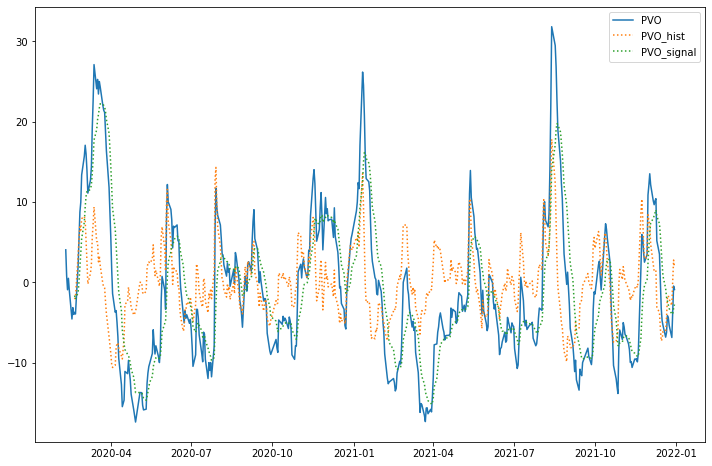

In [42]:
PVO = ta.momentum.pvo(data['Volume'])
PVO_hist  = ta.momentum.pvo_hist(data['Volume'])
PVO_signal = ta.momentum.pvo_signal(data['Volume'])



plt.figure(figsize=(12, 8))

plt.plot(PVO, label = 'PVO', )
plt.plot(PVO_hist, label = 'PVO_hist',linestyle='dotted')
plt.plot(PVO_signal, label = 'PVO_signal',linestyle= "dotted")
plt.legend(loc='best')